In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

def findFiles(path): 
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# 将Unicode字符串转换为纯ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# 构建category_lines字典，每种语言的名字列表
category_lines = {}
all_categories = []

# 读取文件并分成几行
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [3]:
import torch

# 从all_letters中查找字母索引，例如 "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# 仅用于演示，将字母转换为<1 x n_letters> 张量
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 将一行转换为<line_length x 1 x n_letters>，
# 或一个0ne-hot字母向量的数组
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [4]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1) # ([1, 185])
        hidden = self.i2h(combined) # ([1, 128])
        output = self.i2o(combined) # ([1, 18])
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [5]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9646, -2.8499, -2.9114, -2.9327, -2.9351, -2.7883, -2.8006, -2.9122,
         -2.9048, -2.9256, -2.8408, -2.9306, -2.8796, -2.9533, -2.8102, -2.9848,
         -2.9415, -2.7946]], grad_fn=<LogSoftmaxBackward>)


In [6]:
def categoryFromOutput(output):
    _, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('French', 5)


In [9]:
import random

def randomTrainingExample():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Portuguese / line = Gomes
category = Scottish / line = Marshall
category = Chinese / line = Shui
category = Dutch / line = Klein
category = Japanese / line = Takekawa
category = Portuguese / line = Freitas
category = Japanese / line = Ouchi
category = Polish / line = Gorka
category = Korean / line = Shon
category = Dutch / line = Rompa


In [14]:
learning_rate = 0.005 
criterion = nn.NLLLoss()

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    # 将参数的梯度添加到其值中，乘以学习速率
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    return output, loss.item()

In [15]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# 跟踪绘图的损失
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    # 打印迭代的编号，损失，名字和猜测
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
    # 将当前损失平均值添加到损失列表中
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 12s) 2.6508 Albuquerque / Greek ✗ (Portuguese)
10000 10% (0m 24s) 2.0372 Elashkin / Russian ✓
15000 15% (0m 37s) 1.9272 Jedrinsky / Polish ✗ (Russian)
20000 20% (0m 50s) 1.9749 Gridchin / Irish ✗ (Russian)
25000 25% (1m 2s) 1.1402 Suh / Chinese ✗ (Korean)
30000 30% (1m 14s) 0.8651 Liatos / Greek ✓
35000 35% (1m 26s) 2.4272 Sabol / Arabic ✗ (Czech)
40000 40% (1m 38s) 2.0184 Mentis / Scottish ✗ (Greek)
45000 45% (1m 50s) 2.7243 Mojjis / Greek ✗ (Czech)
50000 50% (2m 3s) 0.4729 Akkeren / Dutch ✓
55000 55% (2m 15s) 5.4818 Bartosz / Spanish ✗ (Polish)
60000 60% (2m 27s) 1.3054 Moon / Korean ✓
65000 65% (2m 40s) 1.0307 Garcia / Spanish ✗ (Portuguese)
70000 70% (2m 52s) 2.5611 Peerenboom / French ✗ (Dutch)
75000 75% (3m 4s) 2.9196 Jares / Dutch ✗ (Czech)
80000 80% (3m 17s) 0.3263 Jiu / Chinese ✓
85000 85% (3m 29s) 4.1229 Maly / English ✗ (Polish)
90000 90% (3m 42s) 0.8434 Telis / Greek ✓
95000 95% (3m 53s) 0.3818 Malouf / Arabic ✓
100000 100% (4m 5s) 1.6264 Fallon / Scottish ✗ (En

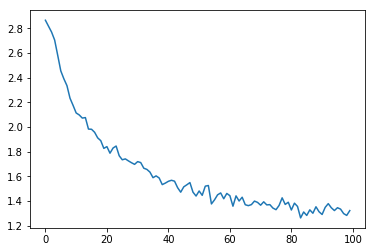

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

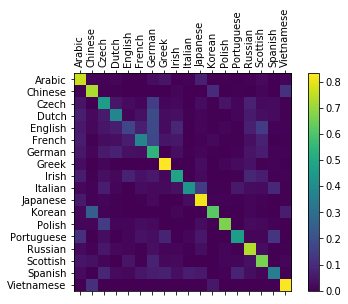

In [19]:
# 在混淆矩阵中跟踪正确的猜测
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 只需返回给定一行的输出
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

# 查看一堆正确猜到的例子和记录
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
# 通过将每一行除以其总和来归一化
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
# 设置绘图
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 设置轴
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 每个刻度线强制标签
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# sphinx_gallery_thumbnail_number = 2
plt.show()

In [29]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        # 获得前N个类别
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [30]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.56) Russian
(-1.02) Czech
(-3.44) English

> Jackson
(-1.28) Russian
(-1.43) English
(-1.62) Scottish

> Satoshi
(-1.06) Japanese
(-1.53) Italian
(-1.73) Arabic
